In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!ls ../data/raw/ielts

ielts_writing_dataset.csv


In [3]:
fp = '../data/raw/ielts/ielts_writing_dataset.csv'
df = pd.read_csv(fp)

In [4]:
df.sample()

,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
978,1,The chart and table below give information abo...,The table chart and the table report informati...,NaN,NaN,NaN,NaN,NaN,6.0


In [5]:
df['Task_Type']==1

0        True
1       False
2        True
3       False
4        True
        ...  
1430    False
1431    False
1432    False
1433    False
1434    False
Name: Task_Type, Length: 1435, dtype: bool

In [6]:
mask1 = df['Task_Type']==1
mask2 = df['Task_Type']==2
df[mask1]['Overall'].value_counts().sort_index()

1.0      1
3.0      1
3.5      4
4.0      5
4.5     13
5.0     48
5.5    103
6.0    129
6.5    128
7.0     91
7.5     69
8.0     36
8.5     14
Name: Overall, dtype: int64

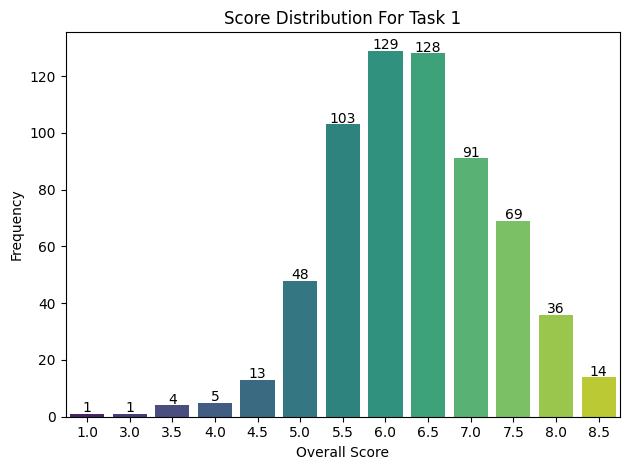

In [7]:
task1 = df[mask1]['Overall'].value_counts().sort_index()

sns.barplot(x=task1.index, y=task1.values, palette='viridis')

for index, value in enumerate(task1.values):
    plt.text(index, value + 0.5, str(value), ha='center')

plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title('Score Distribution For Task 1')
plt.savefig('../plots/IELTS_Score_Dist1.png')
plt.tight_layout()
plt.show()


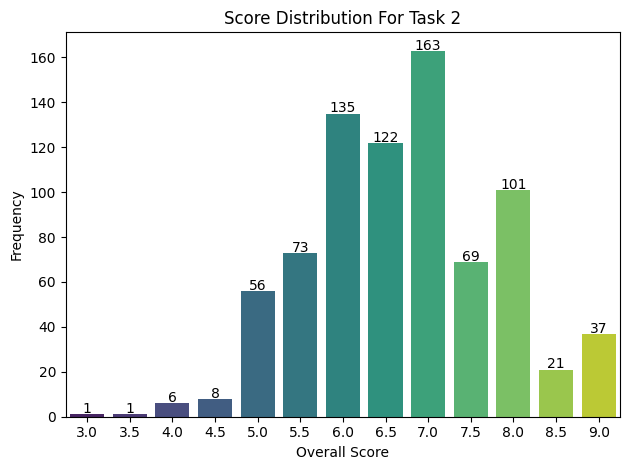

In [8]:
task2 = df[mask2]['Overall'].value_counts().sort_index()

sns.barplot(x=task2.index, y=task2.values, palette='viridis')

for index, value in enumerate(task2.values):
    plt.text(index, value + 0.5, str(value), ha='center')

plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title('Score Distribution For Task 2')
plt.savefig('../plots/IELTS_Score_Dist2.png')
plt.tight_layout()
plt.show()

# Part 2: Visualization of Feature Embeddings

In [39]:
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sys.path.append('../src/features')
from basic_features_1 import FeatureExtractor
# from complex_features2 import ComplexFeatureExtractor
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ginger/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
long_essays = df[mask2]
long_essays.columns

Index(['Task_Type', 'Question', 'Essay', 'Examiner_Commen', 'Task_Response',
       'Coherence_Cohesion', 'Lexical_Resource', 'Range_Accuracy', 'Overall'],
      dtype='object')

In [11]:
# long_essays.reset_index(drop=True, inplace=True)

In [12]:
feature_extractor = FeatureExtractor()

In [13]:
feature_extractor.__dict__

{'nlp': <spacy.lang.en.English at 0x7ff817397d00>,
 'sia': <nltk.sentiment.vader.SentimentIntensityAnalyzer at 0x7ff814f1ffd0>,
 'spell': <spellchecker.spellchecker.SpellChecker at 0x7ff7d1da12c0>,
 'tool': LanguageTool(language=<LanguageTag "en-US">, motherTongue=None)}

In [14]:
basic_df = feature_extractor.extract_features(long_essays, 'Essay')

  0%|          | 0/793 [00:00<?, ?it/s]

In [23]:
# long_essays['Overall'].values

In [22]:
basic_df['Overall'] = long_essays['Overall'].values

In [17]:
# cols = ['Overall',
#        'word_count', 'char_count', 'avg_words_per_sentence', 'sentence_count',
#        'paragraph_count', 'spelling_mistakes', 'grammar_mistakes',
#        'avg_chars_per_word', 'avg_syllables_per_word', 'punctuation_count',
#        'unique_word_count', 'ttr', 'long_word_count', 'short_sentence_count',
#        'complex_sentence_count', 'flesch_kincaid_grade', 'coleman_liau_index']
# basic_df[cols]['Overall'].isna().sum()

/tmp/ipykernel_26742/2319561319.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(basic_df.corr(), annot=True);


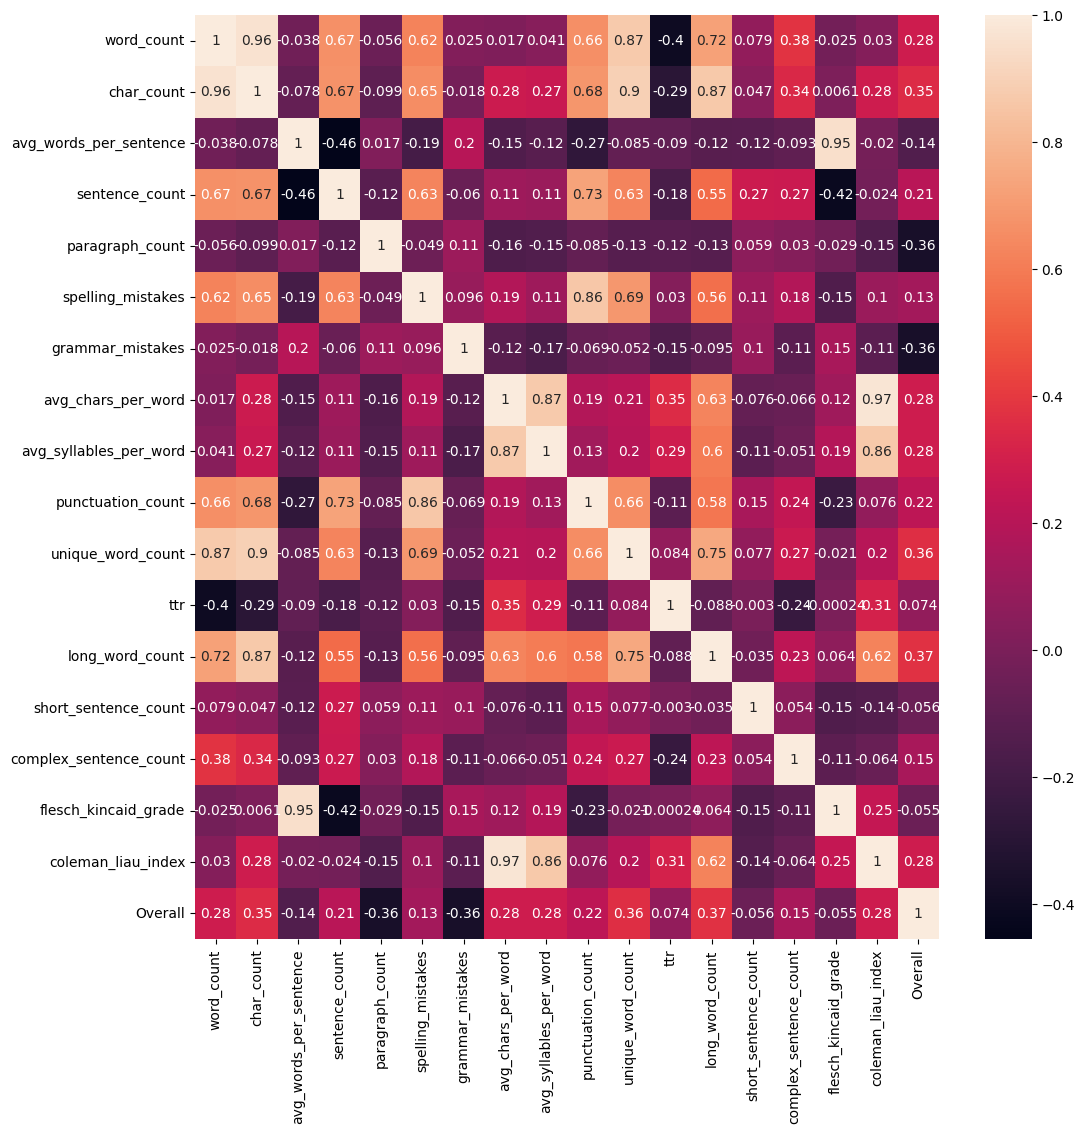

In [44]:
plt.figure(figsize=(12,12))
sns.heatmap(basic_df.corr(), annot=True);
plt.savefig('../plots/heatmap.png')
plt.show();

In [36]:
basic_df.corr()['Overall'].reset_index().sort_values(by='Overall', key=abs, ascending=False)

,index,Overall
17,Overall,1.000000
12,long_word_count,0.371260
6,grammar_mistakes,-0.361879
4,paragraph_count,-0.360389
10,unique_word_count,0.358081
1,char_count,0.346535
16,coleman_liau_index,0.282223
7,avg_chars_per_word,0.281620
0,word_count,0.279973
8,avg_syllables_per_word,0.279710


In [40]:
def categorize_score(score):
    if score <= 5:
        return 'Low'
    elif 5.5 <= score <= 7:
        return 'Medium'
    else:
        return 'Good'

basic_df['Score Category'] = basic_df['Overall'].apply(categorize_score)


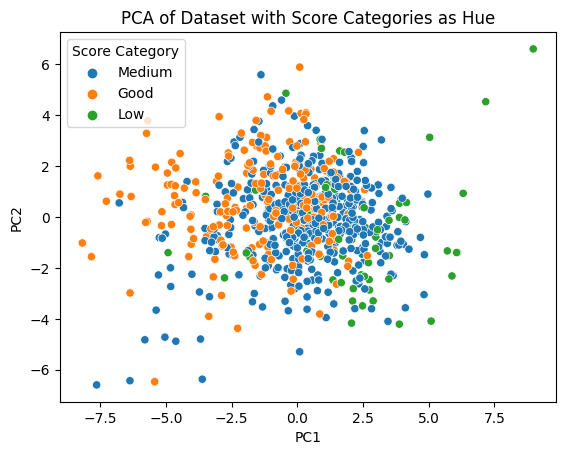

In [61]:
X = basic_df.drop(columns=['Overall', 'Score Category'])  # Features
y = basic_df['Score Category']  # Categorical target

# Standardize the data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA and reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA result into a DataFrame for easy plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Score Category'] = y.values  # Add the 'Score Category' column back for plotting

# Create a scatterplot of the two principal components with the new categories
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_df)

# Add plot title and labels
plt.title('PCA of Dataset with Score Categories as Hue')
plt.savefig('../plots/scatterplot_pca.png')
plt.show()

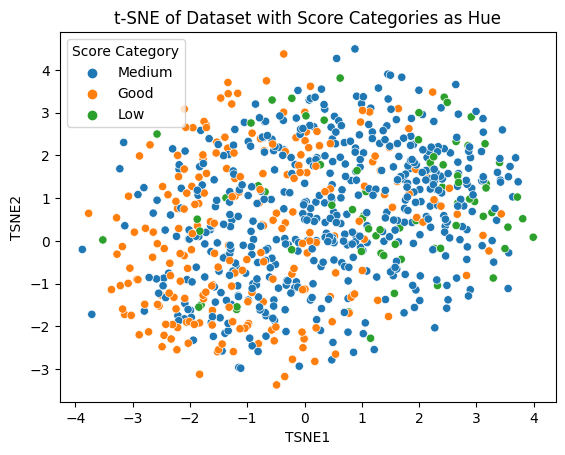

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'Overall' is the target column and 'Score Category' is now your categorical column
X = basic_df.drop(columns=['Overall', 'Score Category'])  # Features
y = basic_df['Score Category']  # Categorical target

# Standardize the data before t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform t-SNE and reduce to 2 components
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert t-SNE result into a DataFrame for easy plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Score Category'] = y.values  # Add the 'Score Category' column back for plotting

# Create a scatterplot of the two t-SNE components with the new categories
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Score Category', data=tsne_df)

# Add plot title and labels
plt.title('t-SNE of Dataset with Score Categories as Hue')
plt.savefig('../plots/scatterplot_tsne.png')
plt.show()


# Using only the features with correlations of above 0.3

In [52]:
basic_df.corr()['Overall'].reset_index().sort_values(by='Overall', key=abs, ascending=False)['index']

/tmp/ipykernel_26742/3160661600.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  basic_df.corr()['Overall'].reset_index().sort_values(by='Overall', key=abs, ascending=False)['index']


17                   Overall
12           long_word_count
6           grammar_mistakes
4            paragraph_count
10         unique_word_count
1                 char_count
16        coleman_liau_index
7         avg_chars_per_word
0                 word_count
8     avg_syllables_per_word
9          punctuation_count
3             sentence_count
14    complex_sentence_count
2     avg_words_per_sentence
5          spelling_mistakes
11                       ttr
13      short_sentence_count
15      flesch_kincaid_grade
Name: index, dtype: object

In [55]:
top5_cols = ["long_word_count", "grammar_mistakes", "paragraph_count", "unique_word_count", "char_count", 'Overall', 'Score Category']
top5 =  basic_df[top5_cols].copy()

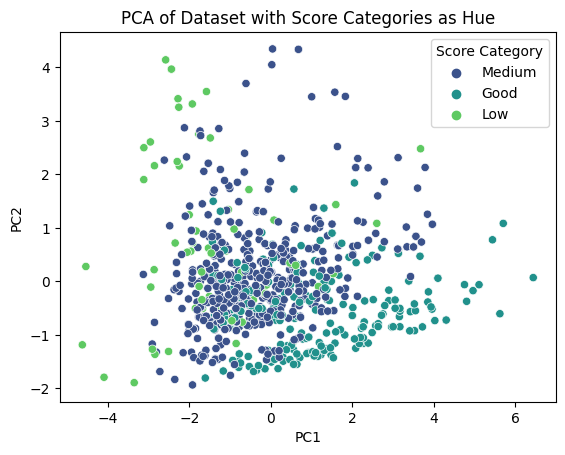

In [56]:

X = top5.drop(columns=['Overall', 'Score Category'])  # Features
y = top5['Score Category']  # Categorical target

# Standardize the data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA and reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA result into a DataFrame for easy plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Score Category'] = y.values  # Add the 'Score Category' column back for plotting

# Create a scatterplot of the two principal components with the new categories
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_df, palette='viridis')

# Add plot title and labels
plt.title('PCA of Dataset with Score Categories as Hue')
plt.savefig('../plots/scatterplot_pca_top5.png')
plt.show()